In [69]:
import numpy as np
import pandas as pd
from collections import Counter
from Data import load_data

rng = np.random.default_rng(42)

players, obj1, obj2, obj3, obj4, obj5, weights = load_data("./nbasalariespoints.csv", "Player", "PS/G▼", "FT", "STL", "3P", "2P", "SALARY")
print(obj5)

[5.1 5.8 7.1 8.2 8.6 5.2 8.6 7.3 6.9 4.9 5.2 4.7 6.4 8.4 5.9 6.1 4.8 5.6
 6.6 5.6 5.9 4.7 5.8 4.8 3.8 5.3 5.2 7.2 5.3 5.  7.3 4.6 8.2 7.2 4.  7.5
 4.6 5.6 5.3 6.1 5.  6.3 6.2 6.1 3.  6.8 3.3 4.5 4.1 3.5 3.9 6.3 4.1 4.1
 2.6 6.7 3.3 4.4 3.8 3.1 3.8 4.1 3.3 3.3 4.9 5.7 3.4 3.9 3.7 3.8 3.5 4.3
 5.2 3.5 5.8 3.4 3.3 3.7 5.2 1.6 3.4 3.8 2.1 4.9 4.3 4.6 5.2 3.4 3.3 3.2
 1.9 4.  4.5 4.1 2.7 1.8 1.7 3.2 3.6 2.9 2.3 2.8 4.4 3.3 4.3 2.5 2.7 4.6
 1.1 2.3 3.2 2.9 3.9 2.7 3.6 3.3 4.  2.5 2.2 4.4 4.  4.4 2.1 2.3 3.7 2.1
 1.9 3.5 2.4 1.9 1.9 3.  3.7 2.8 2.5 2.8 2.  2.2 2.6 2.7 2.2 1.9 3.  3.7
 1.4 3.3 2.  3.4 2.7 2.4 2.8 3.8 2.6 1.7 2.6 2.5 2.8 2.7 3.2 3.5 3.6 2.8
 2.9 2.7 1.4 3.1 1.8 2.4 2.9 3.2 2.1 2.3 2.2 2.1 1.6 3.1 3.2 1.9 1.6 1.8
 1.7 1.9 1.8 2.5 1.4 2.8 3.  2.3 1.  1.4 0.9 2.6 1.8 2.8 1.2 1.3 1.2 3.2
 1.8 2.4 3.1 1.7 3.  2.9 2.9 1.9 2.7 1.3 1.9 1.2 2.7 1.2 1.3 1.6 1.9 2.3
 2.  1.9 2.1 2.4 2.6 2.7 1.1 2.  1.5 1.6 0.9 1.4 1.8 1.  2.5 1.5 2.3 1.2
 2.2 1.4 2.  1.3 1.6 2.  1.2 0.7 1.1 1.7 2.1 0.8 1.

In [70]:
# Create a population of num_teams x team_size, with random values from 0-last index
# Each individual represents a team, and each team has 15 players
def initializePopulation(num_teams, team_size, max_index):
    return rng.integers(0, max_index, (num_teams, team_size), dtype=int)

def calculateValue(individual, obj):
    return np.sum(obj[individual])

def calculateWeight(individual, weights):
    return np.sum(weights[individual])

# Sets the fitness to -inf if the weight exceeds the knapsack capacity, or if there are duplicate players (can't draft the same player twice)
# Otherwise, sets the fitness to the value of the team
# Since there is a limit on how many players can be in each team, don't use value to weight ratio as the fitness
def calculateFitness(individual, weights, capacity, epsilon, primary, objectives):
    indevidual_weight = calculateWeight(individual, weights)
    count = Counter(individual)

    fitness_list = []
    for i in range(len(objectives)):
        if calculateValue(individual, objectives[i]) < epsilon[i]:
            fitness_list.append(-np.inf)
    if (indevidual_weight > capacity) or np.any(np.array(fitness_list) == -np.inf): 
        fitness = -np.inf
    else:
        fitness = calculateValue(individual, primary)

    # Can't choose the same player twice
    for i in range(len(individual)):
        if count[individual[i]] > 1: 
            fitness = -np.inf
            break
    return fitness

# Selects the two best as the parents
def selectParents(capacity, weights, population, epsilon, primary, objectives):
    fitness = []
    for individual in population:
        fitness.append(calculateFitness(individual, weights, capacity, epsilon, primary, objectives))

    fitness = np.array(fitness)
    top_indices = np.argsort(fitness)[-3:] 
    return [population[top_indices[0]], population[top_indices[1]], population[top_indices[2]]]

# Generates a population of the same size as the initial population
# Selects each gene randomly from one of the parents
def generatePopulation(parents, pop_size, team_size, length, mutation_rate=.1):
    population = np.zeros((pop_size, team_size), dtype=int)
    population[0], population[1], population[2] = parents

    for i in range(3, pop_size):
        for j in range(team_size):
            parent_choice = rng.integers(0, 3)
            population[i][j] = parents[parent_choice][j]
            
            # Mutation
            if rng.random() < mutation_rate:
                population[i][j] = rng.integers(0, length)
    return population


# Creates an initial population
# Saves the mean value for the population in each training iteration to plot
# Finds to two best as parents
# Creates a new population using the parents
# Saves only the valid solutions in the final population and returns the one with the highest value
def knapSackGenetic(capacity, weights, training_length, pop_size, team_size, epsilon, primary, objectives):
    max_index = len(weights) - 1
    parents_list = []
    population = initializePopulation(pop_size, team_size, max_index)

    for i in range(training_length):
        parents = selectParents(capacity, weights, population, epsilon, primary, objectives)
        parents_list.append(parents)
        population = generatePopulation(parents, pop_size, team_size, max_index)
    
    valid = []
    for individual in population:
        if calculateFitness(individual, weights, capacity, epsilon, primary, objectives) == -np.inf: continue
        valid.append(individual)

    valid = np.array(valid)
    print(f"Length of valid: {len(valid)}")
    if len(valid) == 0:
        '''
        for i in range(len(parents_list) - 1, 0, -1):
            for j in range(len(parents_list[0]) - 1):
                if calculateFitness(parents_list[i][j], weights, capacity, epsilon, primary, objectives) != -np.inf:
                    valid[0] = parents_list[i][j]
                    break
        '''
        return -1   
    indices = np.argsort([val for val in [calculateValue(ind, primary) for ind in valid]])
    return valid[indices[-1]]


In [71]:
epsilon = [50, 15, 20, 250]
capacity = 150_000_000
training_length = 1000
pop_size = 500
team_size = 15
individual = knapSackGenetic(capacity, weights, training_length, pop_size, team_size, epsilon, obj5, [obj2, obj3, obj4, obj1])

if np.any(individual != -1):
    individual = np.sort(individual)
    print(f"Weight: {calculateWeight(individual, weights):,}")
    print(f"Best Solution: {individual}")
    print(f"Primary (2P): {calculateValue(individual, obj5)}")
    print(f"Secondary 1 (FT): {calculateValue(individual, obj2)}")
    print(f"Secondary 2 (Steals): {calculateValue(individual, obj3)}")
    print(f"Secondary 3 (3P): {calculateValue(individual, obj4)}")
    print(f"Secondary 4 (Points): {calculateValue(individual, obj1)}")


Length of valid: 223
Weight: 143,162,546
Best Solution: [ 0  2  3  4  5  6  7 14 17 18 30 32 35 39 45]
Primary (2P): 104.1
Secondary 1 (FT): 65.6
Secondary 2 (Steals): 17.9
Secondary 3 (3P): 19.999999999999996
Secondary 4 (Points): 333.2


In [72]:
350
77
18
27
95
ordered = np.sort(obj5)[::-1]
print(ordered)
print(np.sum(ordered[0:15]))

[8.6 8.6 8.4 8.2 8.2 7.5 7.3 7.3 7.2 7.2 7.1 6.9 6.8 6.7 6.6 6.4 6.3 6.3
 6.2 6.1 6.1 6.1 5.9 5.9 5.8 5.8 5.8 5.7 5.6 5.6 5.6 5.3 5.3 5.3 5.2 5.2
 5.2 5.2 5.2 5.2 5.1 5.  5.  4.9 4.9 4.9 4.8 4.8 4.7 4.7 4.6 4.6 4.6 4.6
 4.5 4.5 4.4 4.4 4.4 4.4 4.3 4.3 4.3 4.1 4.1 4.1 4.1 4.1 4.  4.  4.  4.
 3.9 3.9 3.9 3.8 3.8 3.8 3.8 3.8 3.8 3.7 3.7 3.7 3.7 3.7 3.6 3.6 3.6 3.5
 3.5 3.5 3.5 3.5 3.4 3.4 3.4 3.4 3.4 3.3 3.3 3.3 3.3 3.3 3.3 3.3 3.3 3.3
 3.2 3.2 3.2 3.2 3.2 3.2 3.2 3.1 3.1 3.1 3.1 3.  3.  3.  3.  3.  2.9 2.9
 2.9 2.9 2.9 2.9 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.7 2.7 2.7 2.7 2.7 2.7
 2.7 2.7 2.7 2.7 2.6 2.6 2.6 2.6 2.6 2.6 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5
 2.4 2.4 2.4 2.4 2.4 2.3 2.3 2.3 2.3 2.3 2.3 2.3 2.3 2.2 2.2 2.2 2.2 2.2
 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.  2.  2.  2.  2.  2.  1.9 1.9 1.9 1.9 1.9
 1.9 1.9 1.9 1.9 1.9 1.9 1.9 1.8 1.8 1.8 1.8 1.8 1.8 1.8 1.8 1.8 1.8 1.7
 1.7 1.7 1.7 1.7 1.7 1.7 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.5 1.5
 1.5 1.5 1.5 1.5 1.5 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4

NameError: name 'vals' is not defined

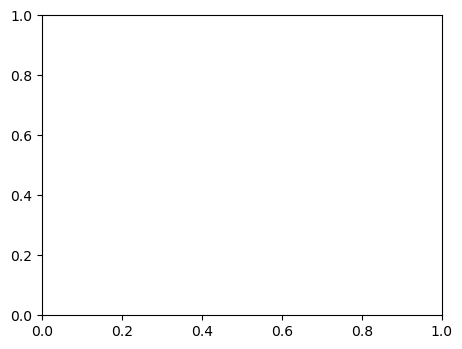

In [73]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(4, 3))
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(vals)
ax.grid(True)
ax.set_xticks(np.arange(0, len(vals) + 1, 25))
ax.set_yticks(np.arange(100, 400, 25))
ax.set_title("Points Increase Across Generations")
ax.set_ylabel("Total Points")
ax.set_xlabel("Generation Number")
plt.show()
print(f"Starting Value: {vals[0]}")
print(f"Ending Value: {vals[-1]}")
print(f"Max value: {np.max(vals)}")

